# **주요 내용**

*   실험

In [0]:
notebookName = "20200517"
notebookName

'20200517'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**plot working time & validation loss and accuracy**

In [0]:
model_names = ["model_{}".format(i) for i in range(3, 33, 1)]

In [0]:
import numpy as np
import os

previous = "20200516_3"
num_models = 3
num_loop = 10
epochs = 200

working_time = np.zeros((num_models, num_loop))
histories = np.zeros((num_models, num_loop, 4, epochs))

for i, model_name in enumerate(model_names):
    history = np.load(os.path.join("/content/drive/My Drive/results", "{}_{}.npz".format(previous, model_name)))

    histories[i % num_models, i // num_models, 0] = history['accuracy']
    histories[i % num_models, i // num_models, 1] = history['val_accuracy']
    histories[i % num_models, i // num_models, 2] = history['loss']
    histories[i % num_models, i // num_models, 3] = history['val_loss']

    working_time[i % num_models, i // num_models] = history['working_time']

In [0]:
avg_working_time = working_time.mean(axis = 1)
avg_histories = histories.mean(axis = 1)

print(avg_working_time.shape, avg_histories.shape)

(3,) (3, 4, 200)


In [0]:
for i in range(num_models):
    print("[model_{}] avg working time: {:.2f} sec".format(i, avg_working_time[i]))

[model_0] avg working time: 1116.99 sec
[model_1] avg working time: 1146.93 sec
[model_2] avg working time: 1151.73 sec


In [0]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [0]:
import matplotlib.pyplot as plt

def plot_histories(avg_histories):
    fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)
    c = ['r', 'g', 'b']
    n = ['model_{}'.format(i) for i in range(1, 4, 1)]

    plt.subplot(1, 2, 1)
    for i, history in enumerate(avg_histories):
        acc = history[0]
        val_acc = history[1]
        plt.plot(np.arange(1, len(val_acc) + 1, 1), 1 - np.array(smooth_curve(val_acc)), color = c[i], label = n[i], alpha = .7)
    plt.title('Validation error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    # plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, history in enumerate(avg_histories):
        loss = history[2]
        val_loss = history[3]
        plt.plot(np.arange(1, len(val_loss) + 1, 1), smooth_curve(val_loss), color = c[i], label = n[i], alpha = .7)
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

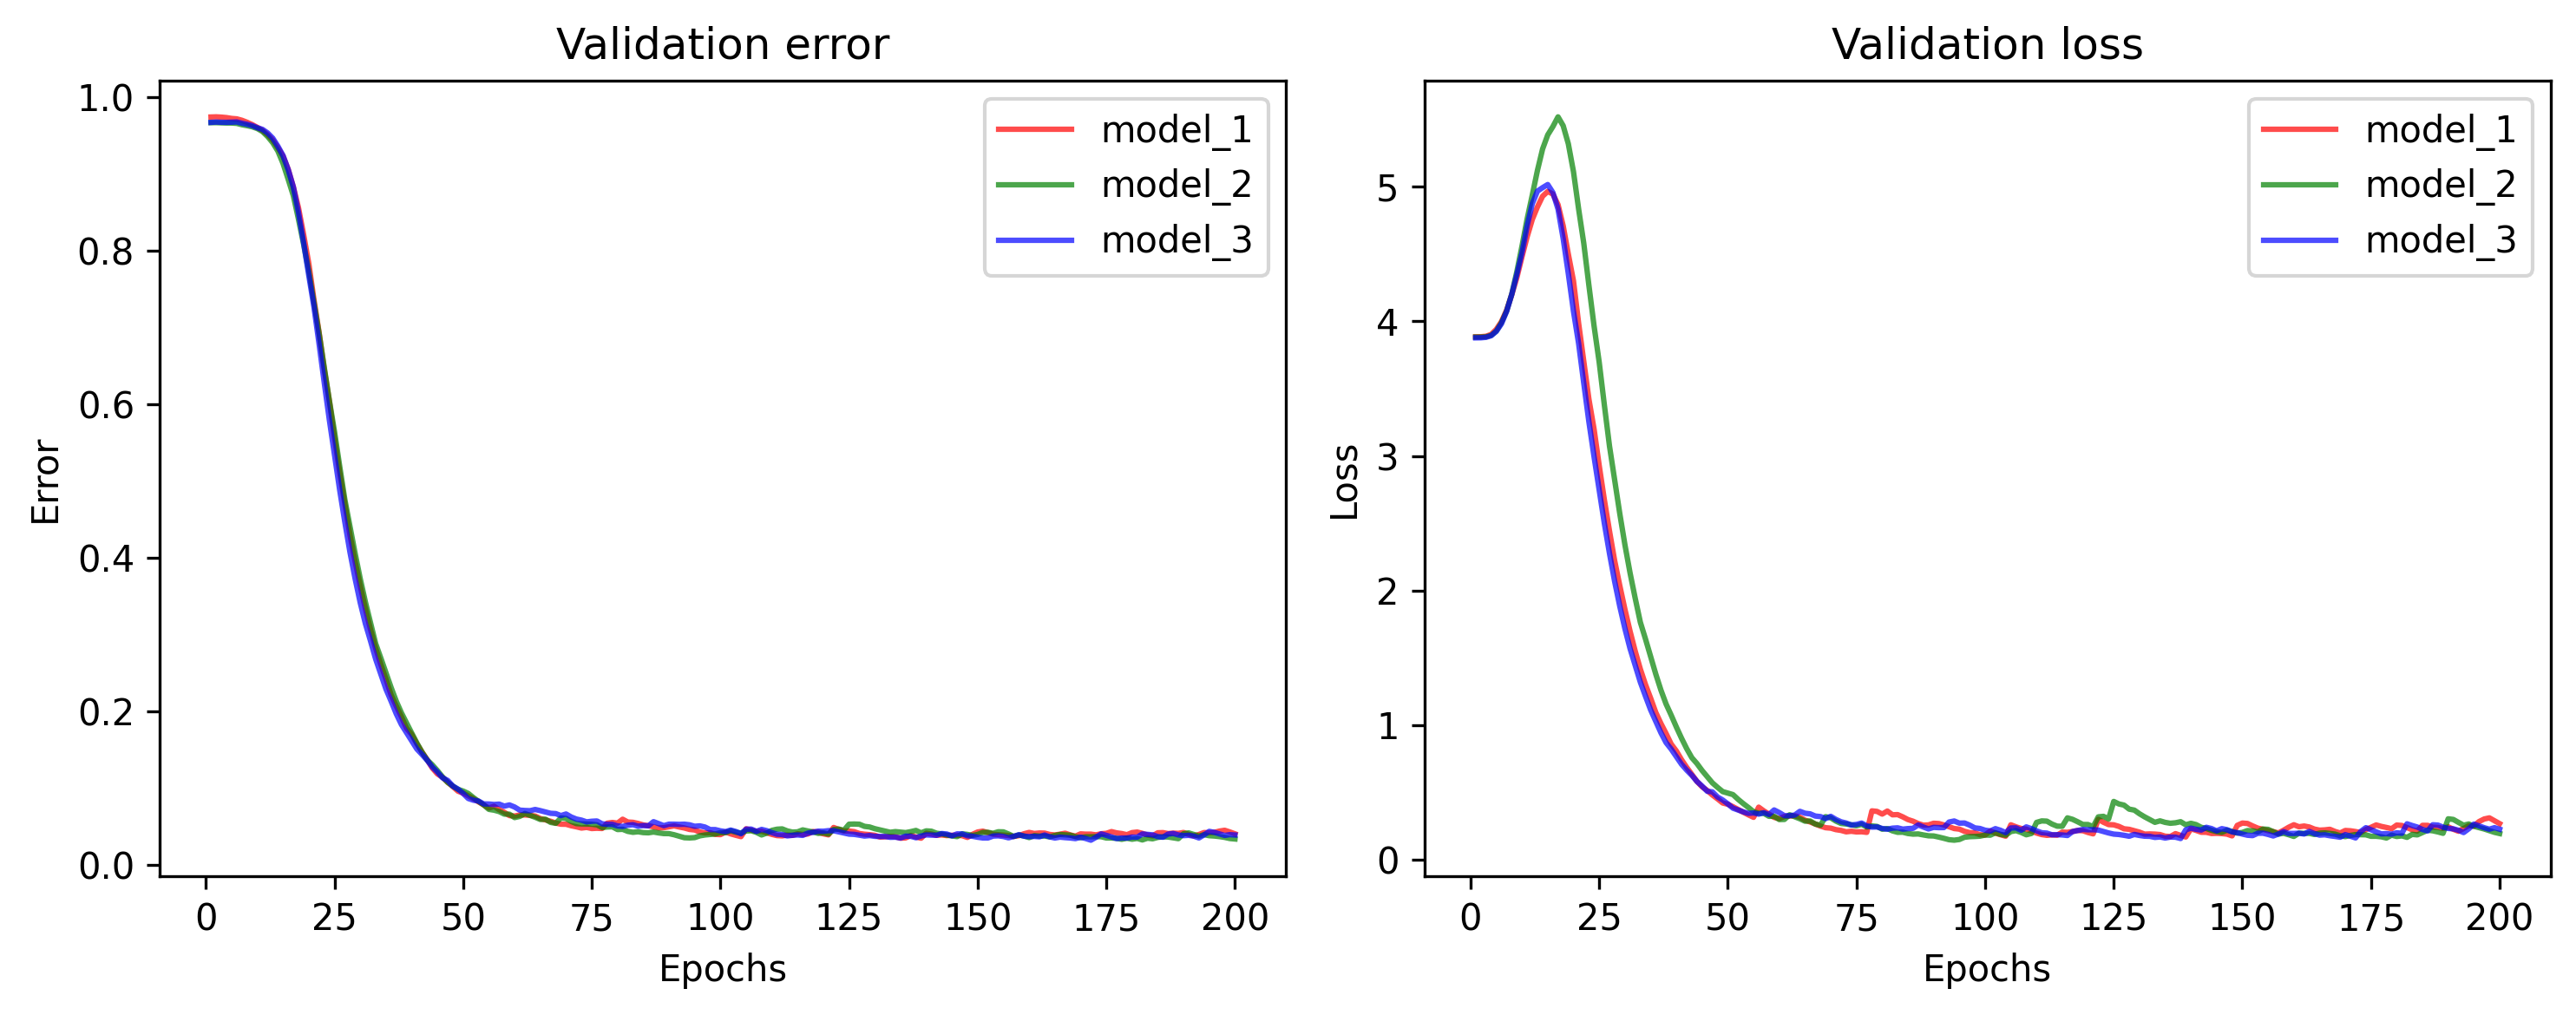

In [0]:
plot_histories(avg_histories)

**plot test error & predictions (CMC Curve)**

In [0]:
test_labels = np.zeros((1000, 50))
num_labels = 50

In [0]:
preds = np.zeros((num_models, num_loop, test_labels.shape[0], test_labels.shape[1])) # (3, 10, 1000, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    preds[i % num_models, i // num_models] = pred

In [0]:
test_errors = np.zeros((num_models, num_loop))

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)
    
    test_errors[i % num_models, i // num_models] = np.sum(np.not_equal(np.argmax(pred, axis = 1), y)) / test_labels.shape[0]

In [0]:
1 - test_errors

array([[0.986, 0.987, 0.989, 0.958, 0.974, 0.973, 0.99 , 0.949, 0.987,
        0.981],
       [0.992, 0.991, 0.992, 0.978, 0.95 , 0.984, 0.993, 0.977, 0.881,
        0.984],
       [0.904, 0.981, 0.972, 0.981, 0.953, 0.987, 0.983, 0.955, 0.972,
        0.954]])

In [0]:
for i in range(num_models):
    print("[model_{}] avg test error: {:.4f}".format(i, test_errors[i].mean()))

[model_0] avg test error: 0.0226
[model_1] avg test error: 0.0278
[model_2] avg test error: 0.0358


In [0]:
cmcs = np.zeros((num_models, num_loop, 50)) # (3, 10, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)

    a = np.array([sorted(pred[j], reverse = True).index(pred[j, y[j]]) for j in range(len(y))]) # 정답의 순위    
    cmcs[i % num_models, i // num_models] = np.array([len(a[a<=j]) / 1000 for j in range(50)])

In [0]:
print(cmcs)

[[[0.986 0.996 0.999 ... 1.    1.    1.   ]
  [0.987 0.995 0.999 ... 1.    1.    1.   ]
  [0.989 0.996 0.997 ... 1.    1.    1.   ]
  ...
  [0.949 0.985 0.991 ... 0.999 1.    1.   ]
  [0.987 0.996 0.998 ... 1.    1.    1.   ]
  [0.981 0.997 0.998 ... 1.    1.    1.   ]]

 [[0.992 0.996 0.999 ... 1.    1.    1.   ]
  [0.991 0.997 0.998 ... 1.    1.    1.   ]
  [0.992 0.997 0.998 ... 1.    1.    1.   ]
  ...
  [0.977 0.995 0.996 ... 1.    1.    1.   ]
  [0.881 0.959 0.98  ... 1.    1.    1.   ]
  [0.984 0.995 0.997 ... 1.    1.    1.   ]]

 [[0.904 0.972 0.989 ... 1.    1.    1.   ]
  [0.981 0.996 0.998 ... 1.    1.    1.   ]
  [0.972 0.991 0.995 ... 1.    1.    1.   ]
  ...
  [0.955 0.983 0.992 ... 1.    1.    1.   ]
  [0.972 0.994 0.994 ... 1.    1.    1.   ]
  [0.954 0.983 0.991 ... 1.    1.    1.   ]]]


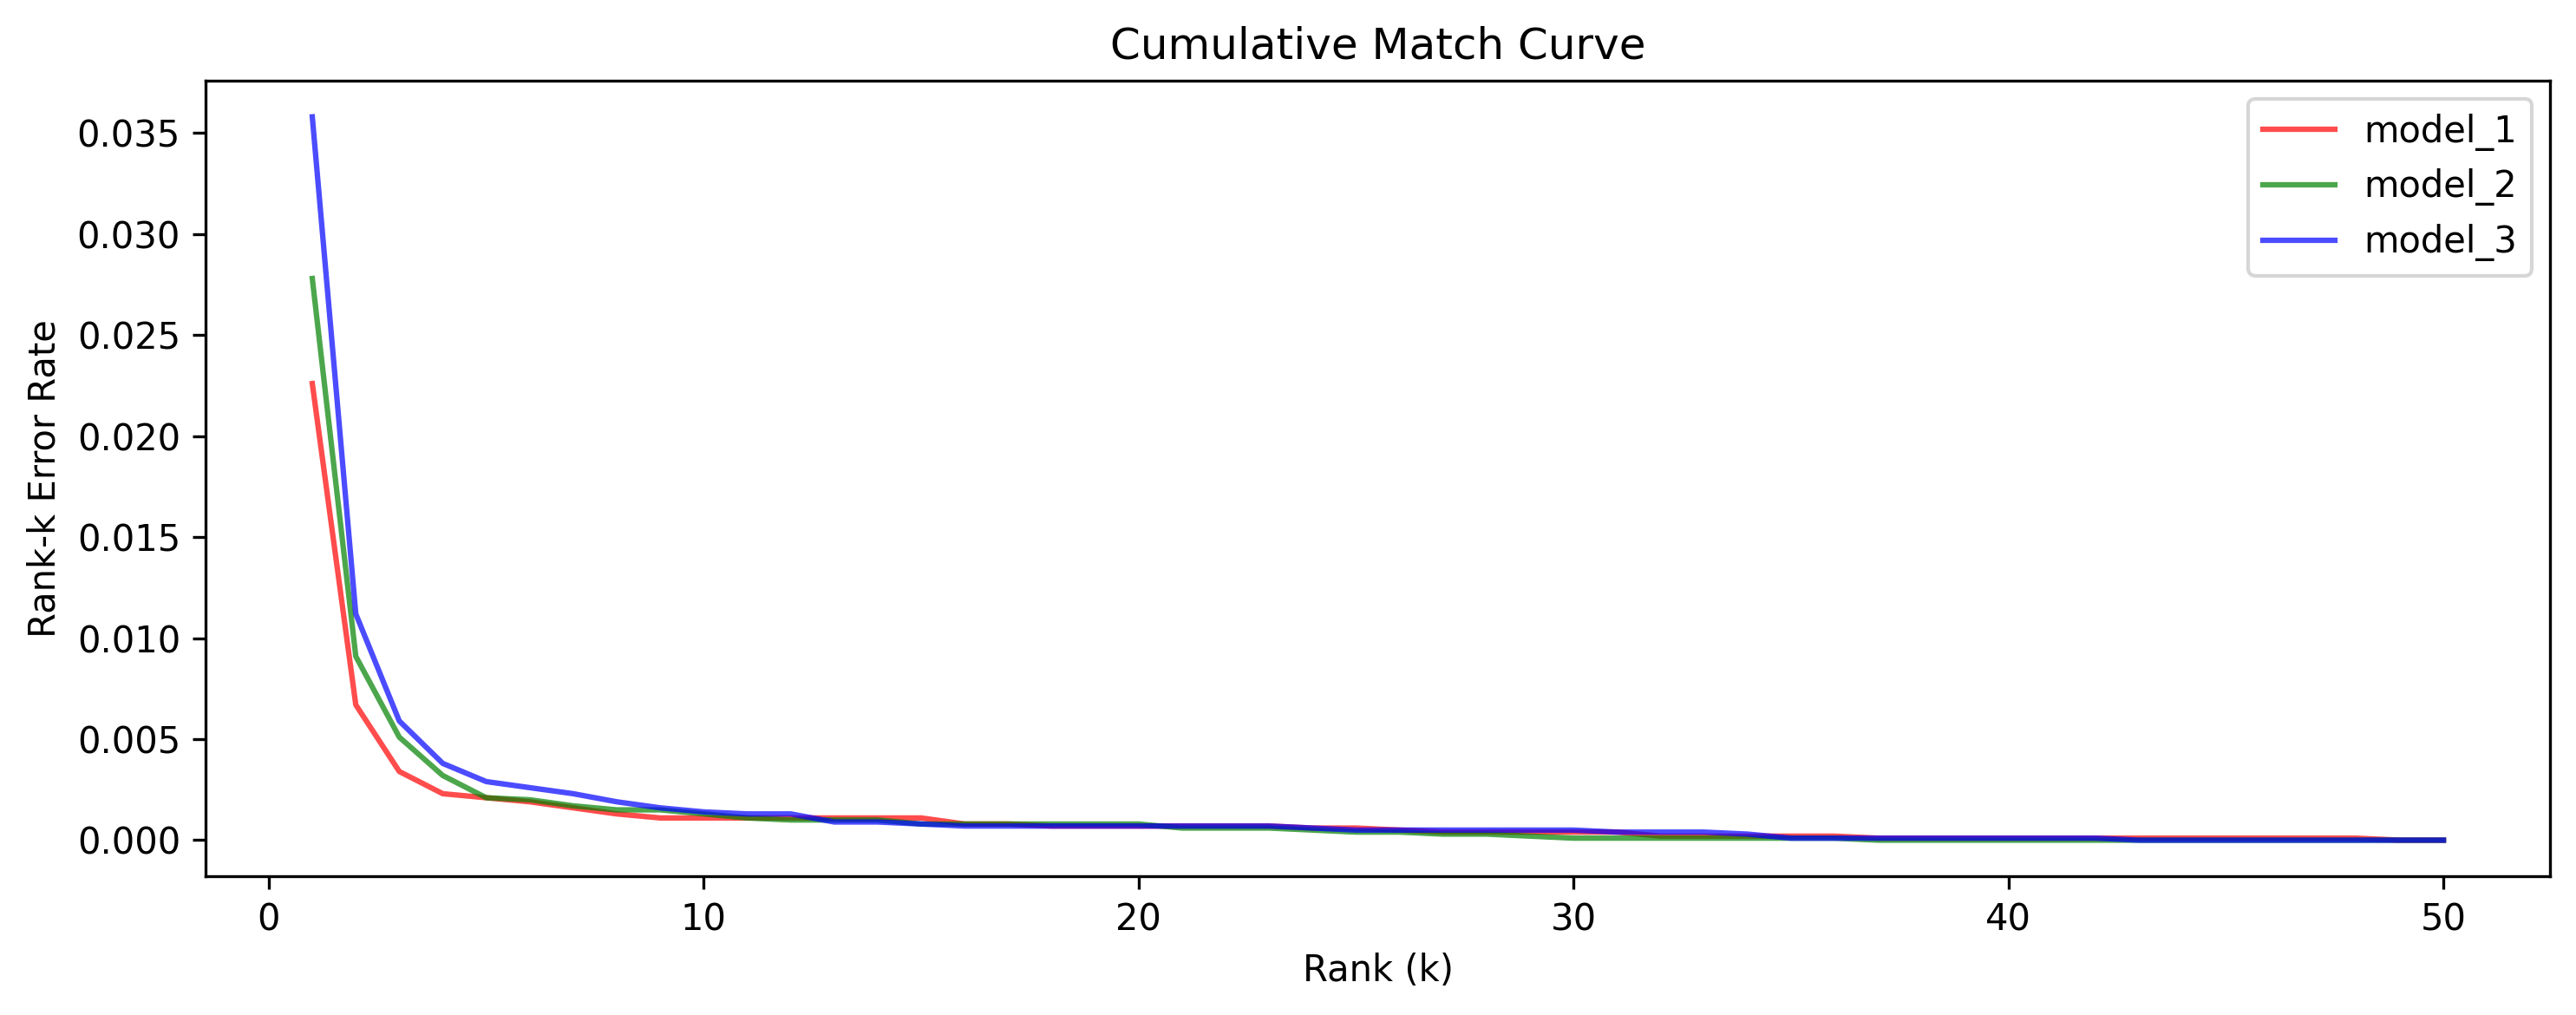

In [0]:
avg_cmcs = cmcs.mean(axis = 1)

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

for i, model_cmc in enumerate(avg_cmcs):
    c = ['r', 'g', 'b']
    n = ['model_{}'.format(i) for i in range(1, 4, 1)]

    plt.plot(np.arange(1, 51, 1), 1 - model_cmc, color = c[i], label = n[i], alpha = 0.7)

plt.title('Cumulative Match Curve')
plt.xlabel('Rank (k)')
plt.ylabel('Rank-k Error Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
for i, cmc in enumerate(avg_cmcs):
    print("[model_{}] top 1 error: {:.4f}, top 5 error: {:.4f}".format(i, cmc[0], cmc[4]))

[model_0] top 1 error: 0.9774, top 5 error: 0.9979
[model_1] top 1 error: 0.9722, top 5 error: 0.9979
[model_2] top 1 error: 0.9642, top 5 error: 0.9971
